# Python Script to Get Cumulative CPUs for a Chosen GraphCat ID, Group, and SubGroup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import great_expectations as ge
import ipywidgets as widgets  # library for creating widgets for jupyter notebooks
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import time
from pathlib import Path
from win10toast import ToastNotifier
import os
import pyodbc  # used for connecting to ODBC data sources
import pandas as pd  # data analysis library
plt.rcParams['figure.figsize'] = [12, 8]
pd.options.display.max_rows=1000
pd.options.display.max_columns=100

### RVMS Database Credentials:

In [2]:
userid_rvms = os.environ['windowsuser']
pw_rvms     = os.environ['windowspwd']
dsn_rvms = 'HDC-SQLP-RVMS'

### Create a list of GraphCat Descriptions at GraphCat Level

In [3]:
%%time

cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
SELECT
    DISTINCT
    GC_MASTER.GraphCatID,
    GC_MASTER.GraphCatDesc,
    GC_MASTER.GraphCatType,
    CONCAT(CAST(GC_MASTER.GraphCatID as VARCHAR), ' ', GC_MASTER.GraphCatDesc) AS GraphCat

FROM
    dbo.tbl_GraphCatMaster as GC_MASTER

WHERE
    GC_MASTER.GraphCatType = 'R'
    AND GC_MASTER.GraphCatDesc like 'R %'
    """

gc_list = pd.read_sql(sql, cnxn, index_col=None)

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 1.02 s


In [4]:
gc_list.head()

,GraphCatID,GraphCatDesc,GraphCatType,GraphCat
0,1,R MAP TL 2001 KA,R,1 R MAP TL 2001 KA
1,2,R MAP TL 2001 KC,R,2 R MAP TL 2001 KC
2,3,R MAP TL 2001 KJ,R,3 R MAP TL 2001 KJ
3,4,R MAP CL 2001 KA,R,4 R MAP CL 2001 KA
4,5,R MAP CL 2001 KC,R,5 R MAP CL 2001 KC


### Could not find an easy solution to split delimited string into multiple columns using native SQL Server SQL, so resorted to using Python functions:

In [5]:
def getModelYear(row) -> str:
    word_token = row['GraphCatDesc'].split()
    
    model_year = word_token[3]
    
    if model_year.isdigit():
        return model_year
    else:
        return word_token[4]
        

def getFactoryCode(row) -> str:
    word_token = row['GraphCatDesc'].split()
    factory_code = word_token[1]
    
    return factory_code.upper()

def getModelName(row) -> str:
    word_token = row['GraphCatDesc'].split()
    model_name = word_token[2]
    
    return model_name.upper()

### Add Model Year, Factory, and Model Name columns

In [6]:
gc_list['ModelYear'] = gc_list.apply(getModelYear, axis='columns')
gc_list['Factory'] = gc_list.apply(getFactoryCode, axis='columns')
gc_list['ModelName'] = gc_list.apply(getModelName, axis='columns')

In [7]:
gc_list.head()

,GraphCatID,GraphCatDesc,GraphCatType,GraphCat,ModelYear,Factory,ModelName
0,1,R MAP TL 2001 KA,R,1 R MAP TL 2001 KA,2001,MAP,TL
1,2,R MAP TL 2001 KC,R,2 R MAP TL 2001 KC,2001,MAP,TL
2,3,R MAP TL 2001 KJ,R,3 R MAP TL 2001 KJ,2001,MAP,TL
3,4,R MAP CL 2001 KA,R,4 R MAP CL 2001 KA,2001,MAP,CL
4,5,R MAP CL 2001 KC,R,5 R MAP CL 2001 KC,2001,MAP,CL


### Need to allow user to limit GraphCats by model year(s), factory(ies), and model:

In [17]:
years_str = input("Enter model years separated by comma: ").replace(' ', '')
factories_str = input("Enter one or more factory codes separated by comma: ").replace(' ','').upper()
models_str = input("Enter ONLY ONE model name: ").replace(' ', '').upper()

Enter model years separated by comma: 2017,2018
Enter one or more factory codes separated by comma: elp,hmi,hcm
Enter ONLY ONE model name: crv


In [18]:
models_str

'CRV'

In [19]:
years_list = years_str.split(',')

In [20]:
years_list

['2017', '2018']

In [25]:
factories_list = factories_str.split(',')

In [26]:
factories = '|'.join(factories_list)

In [27]:
factories

'ELP|HMI|HCM'

In [28]:
year_criteria = gc_list['ModelYear'].isin(years_list)
factory_criteria = gc_list['Factory'].str.contains(factories)
model_criteria = gc_list['ModelName'].str.contains(model)

In [29]:
gc_list_final = gc_list[(year_criteria) & (factory_criteria) & (model_criteria)]

In [30]:
graphcats = gc_list_final['GraphCat'].tolist()

In [31]:
graphcats

['1295 R ELP CRV 2017 4WD KA',
 '1296 R ELP CRV 2017 2WD KA',
 '1357 R HCM CRV 2017 2WD KA',
 '1360 R HCM CRV 2017 2WD KC',
 '1424 R HCM CRV 2017 4WD KC',
 '1437 R HCM CRV 2017 4WD KA',
 '1447 R HMI CRV 2017 2WD KA',
 '1481 R HMI CRV 2018 2WD KA',
 '1492 R HCM CRV 2018 2WD KA',
 '1493 R HCM CRV 2018 4WD KA',
 '1501 R ELP CRV 2018 2WD KA',
 '1502 R ELP CRV 2018 4WD KA',
 '1503 R ELP CRV 2018 2WD KC',
 '1504 R ELP CRV 2018 4WD KC',
 '1554 R HMI CRV 2018 4WD KA',
 '1570 R HCM CRV 2018 2WD KC',
 '1571 R HCM CRV 2018 4WD KC']

### Get Cumulative CPUs at GraphCat Level

In [32]:
%%time

"""
gc_id_entry = input("Enter one or more GraphCat IDs separated by comma: ")
gc_id_list = [gc.strip() for gc in gc_id_entry.split(',')]
number_of_gc = len(gc_id_list)
"""
gc_list = widgets.SelectMultiple(
    options=graphcats,
    index=list(range(len(graphcats))),
    rows=20,
    description='GraphCats',
    disabled=False
)
display(gc_list)

months_list = ['60 months', '96 months', '180 months']
def createActualvsBudgetedCpu(months=months_list):
    cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

    cnxn = pyodbc.connect(cnxn_string)
    cursor = cnxn.cursor()
    
    gc_id_list = gc_list.value
    number_of_gc = len(gc_id_list)

    # Copy/Paste your SQL text here
    sql = """
    WITH TEMP AS (

    SELECT
        GC_Budget.SaleMonth,
        GC_Master.GraphCatID,
        GC_Master.GraphCatDesc as GraphCat,
        CummActual_CPU as CumActual_CPU,
        CummBudgeted_Cpu as CumBudgeted_CPU

    FROM dbo.tbl_GraphCat_BudgetedMatrix as GC_Budget

        LEFT JOIN dbo.tbl_GC_GRPS AS GC_GRPS ON
        GC_Budget.GC_GRP_ID = GC_GRPS.GC_GRP_ID

        LEFT JOIN dbo.tbl_MQ_GRPKEYS AS MQ_GRPKEYS ON
        GC_GRPS.GRPKEY_ID = MQ_GRPKEYS.GRPKEY_ID

        LEFT JOIN dbo.tbl_MQ_GRPS AS MQ_GRPS ON
        MQ_GRPKEYS.GRP_ID = MQ_GRPS.GRP_ID

        LEFT JOIN dbo.tbl_MQ_SUBGRPS AS MQ_SUBGRPS ON
        MQ_GRPKEYS.SUBGRP_ID = MQ_SUBGRPS.SUBGRP_ID

        LEFT JOIN dbo.tbl_GraphCatMaster as GC_Master ON
        GC_GRPS.GraphCatID = GC_Master.GraphCatID


    WHERE
        GC_Master.GraphCatID IN(%s)

    )

    SELECT
        SaleMonth,
        GraphCatID,
        GraphCat,
        /**
        CASE
            WHEN CumActual_CPU = 0 THEN NULL
        ELSE
            CumActual_CPU
        END AS CumActual_CPU,  **/
        CumActual_CPU,
        CumBudgeted_CPU

    FROM
        TEMP

    ORDER BY
        SaleMonth
        """ % (",".join("?" * number_of_gc))
    
    parameter_list = []
    for id in gc_id_list:
        parameter_list.append(int(id.split(' ')[0]))

    global cum_actual_budgeted_cpu
    
    cum_actual_budgeted_cpu = pd.read_sql(sql, cnxn, index_col=None, params=parameter_list)

    # For large data (data > RAM, use chunking):
    """
    for c in pd.read_sql(sql, cnxn, chunksize=10000):
        c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

    # Close connections
    cursor.close()
    cnxn.close()
    
interact_manual(createActualvsBudgetedCpu);

SelectMultiple(description='GraphCats', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16), opti…

interactive(children=(Dropdown(description='months', options=('60 months', '96 months', '180 months'), value='…

Wall time: 53.1 ms


In [113]:
cum_actual_budgeted_cpu.to_excel(r'D:\temp\temp.xlsx', index=False)

In [33]:
cum_actual_budgeted_cpu.head()

,SaleMonth,GraphCatID,GraphCat,CumActual_CPU,CumBudgeted_CPU
0,2016-12,1295,R ELP CRV 2017 4WD KA,NaN,0.000000
1,2016-12,1360,R HCM CRV 2017 2WD KC,NaN,0.000000
2,2016-12,1360,R HCM CRV 2017 2WD KC,NaN,0.000000
3,2016-12,1295,R ELP CRV 2017 4WD KA,NaN,0.003753
4,2016-12,1295,R ELP CRV 2017 4WD KA,NaN,0.096839


In [34]:
pivoted = cum_actual_budgeted_cpu.pivot_table(index=['SaleMonth'], columns=['GraphCat'], values=['CumActual_CPU','CumBudgeted_CPU'], aggfunc='sum')

In [35]:
pivoted

CumActual_CPU                                              \
GraphCat  R ELP CRV 2017 2WD KA R ELP CRV 2017 4WD KA R ELP CRV 2018 2WD KA   
SaleMonth                                                                     
2016-12                  0.1167                0.0539                   NaN   
2017-01                  6.6661                5.4830                   NaN   
2017-02                  7.8838                8.3504                   NaN   
2017-03                  6.8187                9.2267                   NaN   
2017-04                  7.1831                9.7277                   NaN   
2017-05                  7.6771               11.0236                   NaN   
2017-06                  8.5907               12.9937                   NaN   
2017-07                 12.5621               15.5678                   NaN   
2017-08                 14.8113               17.8772                   NaN   
2017-09                 17.4456               19.7795                   NaN   
2017-10                 19.2298               21.9674                   NaN   
2017-11                 21.0093               23.5711                   NaN   
2017-12                 22.9173               26.1560                0.0424   
2018-01                 24.7930               29.7651                0.6623   
2018-02                 27.4566               35.5290                1.2966   
2018-03                 30.5094               40.0174                1.7067   
2018-04                 34.3842               44.9219                2.8330   
2018-05                 38.0684               49.9445                4.0171   
2018-06                 42.9115               53.8196                5.4467   
2018-07                 47.8718               56.8760                6.7006   
2018-08                 53.6020               61.3522                8.7710   
2018-09                 59.6263               64.9385               10.3481   
2018-10                 66.7291               69.6093               12.2874   
2018-11                 73.0116               73.8991               13.8378   
2018-12                 77.4577               77.8194               15.0188   
2019-01                 81.0569               82.6168               16.2736   
2019-02                 87.7148               86.6153               17.7805   
2019-03                  0.0000                0.0000                0.0000   
2019-04                  0.0000                0.0000                0.0000   
2019-05                  0.0000                0.0000                0.0000   
2019-06                  0.0000                0.0000                0.0000   
2019-07                  0.0000                0.0000                0.0000   
2019-08                  0.0000                0.0000                0.0000   
2019-09                  0.0000                0.0000                0.0000   
2019-10                  0.0000                0.0000                0.0000   
2019-11                  0.0000                0.0000                0.0000   
2019-12                  0.0000                0.0000                0.0000   
2020-01                  0.0000                0.0000                0.0000   
2020-02                  0.0000                0.0000                0.0000   
2020-03                  0.0000                0.0000                0.0000   
2020-04                  0.0000                0.0000                0.0000   
2020-05                  0.0000                0.0000                0.0000   
2020-06                  0.0000                0.0000                0.0000   
2020-07                  0.0000                0.0000                0.0000   
2020-08                  0.0000                0.0000                0.0000   
2020-09                  0.0000                0.0000                0.0000   
2020-10                  0.0000                0.0000                0.0000   
2020-11                  0.0000                0.0000               

### From above, we see that the Actual and Budgeted CPU header is at the top level and we want them to be actually appended to the lower level headers

#### We want the actual and budgeted header to be part of the graphcat description header, so how do we concatenate them together?

In [36]:
pivoted.columns.get_level_values(0).tolist()

['CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumActual_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU',
 'CumBudgeted_CPU']

In [37]:
pivoted.columns.get_level_values(1).tolist()

['R ELP CRV 2017 2WD KA',
 'R ELP CRV 2017 4WD KA',
 'R ELP CRV 2018 2WD KA',
 'R ELP CRV 2018 2WD KC',
 'R ELP CRV 2018 4WD KA',
 'R ELP CRV 2018 4WD KC',
 'R HCM CRV 2017 2WD KA',
 'R HCM CRV 2017 2WD KC',
 'R HCM CRV 2017 4WD KA',
 'R HCM CRV 2017 4WD KC',
 'R HCM CRV 2018 2WD KA',
 'R HCM CRV 2018 2WD KC',
 'R HCM CRV 2018 4WD KA',
 'R HCM CRV 2018 4WD KC',
 'R HMI CRV 2017 2WD KA',
 'R HMI CRV 2018 2WD KA',
 'R HMI CRV 2018 4WD KA',
 'R ELP CRV 2017 2WD KA',
 'R ELP CRV 2017 4WD KA',
 'R ELP CRV 2018 2WD KA',
 'R ELP CRV 2018 2WD KC',
 'R ELP CRV 2018 4WD KA',
 'R ELP CRV 2018 4WD KC',
 'R HCM CRV 2017 2WD KA',
 'R HCM CRV 2017 2WD KC',
 'R HCM CRV 2017 4WD KA',
 'R HCM CRV 2017 4WD KC',
 'R HCM CRV 2018 2WD KA',
 'R HCM CRV 2018 2WD KC',
 'R HCM CRV 2018 4WD KA',
 'R HCM CRV 2018 4WD KC',
 'R HMI CRV 2017 2WD KA',
 'R HMI CRV 2018 2WD KA',
 'R HMI CRV 2018 4WD KA']

#### SOLUTION: Use Python's join function!

In [38]:
new_column_names = ':'.join([a + ' ' + b for a,b in zip(pivoted.columns.get_level_values(1).tolist(), 
                                                        pivoted.columns.get_level_values(0).tolist())]).split(':')

In [39]:
new_column_names

['R ELP CRV 2017 2WD KA CumActual_CPU',
 'R ELP CRV 2017 4WD KA CumActual_CPU',
 'R ELP CRV 2018 2WD KA CumActual_CPU',
 'R ELP CRV 2018 2WD KC CumActual_CPU',
 'R ELP CRV 2018 4WD KA CumActual_CPU',
 'R ELP CRV 2018 4WD KC CumActual_CPU',
 'R HCM CRV 2017 2WD KA CumActual_CPU',
 'R HCM CRV 2017 2WD KC CumActual_CPU',
 'R HCM CRV 2017 4WD KA CumActual_CPU',
 'R HCM CRV 2017 4WD KC CumActual_CPU',
 'R HCM CRV 2018 2WD KA CumActual_CPU',
 'R HCM CRV 2018 2WD KC CumActual_CPU',
 'R HCM CRV 2018 4WD KA CumActual_CPU',
 'R HCM CRV 2018 4WD KC CumActual_CPU',
 'R HMI CRV 2017 2WD KA CumActual_CPU',
 'R HMI CRV 2018 2WD KA CumActual_CPU',
 'R HMI CRV 2018 4WD KA CumActual_CPU',
 'R ELP CRV 2017 2WD KA CumBudgeted_CPU',
 'R ELP CRV 2017 4WD KA CumBudgeted_CPU',
 'R ELP CRV 2018 2WD KA CumBudgeted_CPU',
 'R ELP CRV 2018 2WD KC CumBudgeted_CPU',
 'R ELP CRV 2018 4WD KA CumBudgeted_CPU',
 'R ELP CRV 2018 4WD KC CumBudgeted_CPU',
 'R HCM CRV 2017 2WD KA CumBudgeted_CPU',
 'R HCM CRV 2017 2WD KC Cu

#### From above, we now have column headers labels we wish to have!  But...

In [40]:
pivoted.columns

MultiIndex(levels=[['CumActual_CPU', 'CumBudgeted_CPU'], ['R ELP CRV 2017 2WD KA', 'R ELP CRV 2017 4WD KA', 'R ELP CRV 2018 2WD KA', 'R ELP CRV 2018 2WD KC', 'R ELP CRV 2018 4WD KA', 'R ELP CRV 2018 4WD KC', 'R HCM CRV 2017 2WD KA', 'R HCM CRV 2017 2WD KC', 'R HCM CRV 2017 4WD KA', 'R HCM CRV 2017 4WD KC', 'R HCM CRV 2018 2WD KA', 'R HCM CRV 2018 2WD KC', 'R HCM CRV 2018 4WD KA', 'R HCM CRV 2018 4WD KC', 'R HMI CRV 2017 2WD KA', 'R HMI CRV 2018 2WD KA', 'R HMI CRV 2018 4WD KA']],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]],
           names=[None, 'GraphCat'])

#### ...we need to remove the top level (0) from the dataframe's ```columns``` attribute and then substitute the column names with the desired/new column names:

In [41]:
pivoted.columns = pivoted.columns.droplevel(0)
pivoted.columns = new_column_names

In [42]:
pivoted

,R ELP CRV 2017 2WD KA CumActual_CPU,R ELP CRV 2017 4WD KA CumActual_CPU,R ELP CRV 2018 2WD KA CumActual_CPU,R ELP CRV 2018 2WD KC CumActual_CPU,R ELP CRV 2018 4WD KA CumActual_CPU,R ELP CRV 2018 4WD KC CumActual_CPU,R HCM CRV 2017 2WD KA CumActual_CPU,R HCM CRV 2017 2WD KC CumActual_CPU,R HCM CRV 2017 4WD KA CumActual_CPU,R HCM CRV 2017 4WD KC CumActual_CPU,R HCM CRV 2018 2WD KA CumActual_CPU,R HCM CRV 2018 2WD KC CumActual_CPU,R HCM CRV 2018 4WD KA CumActual_CPU,R HCM CRV 2018 4WD KC CumActual_CPU,R HMI CRV 2017 2WD KA CumActual_CPU,R HMI CRV 2018 2WD KA CumActual_CPU,R HMI CRV 2018 4WD KA CumActual_CPU,R ELP CRV 2017 2WD KA CumBudgeted_CPU,R ELP CRV 2017 4WD KA CumBudgeted_CPU,R ELP CRV 2018 2WD KA CumBudgeted_CPU,R ELP CRV 2018 2WD KC CumBudgeted_CPU,R ELP CRV 2018 4WD KA CumBudgeted_CPU,R ELP CRV 2018 4WD KC CumBudgeted_CPU,R HCM CRV 2017 2WD KA CumBudgeted_CPU,R HCM CRV 2017 2WD KC CumBudgeted_CPU,R HCM CRV 2017 4WD KA CumBudgeted_CPU,R HCM CRV 2017 4WD KC CumBudgeted_CPU,R HCM CRV 2018 2WD KA CumBudgeted_CPU,R HCM CRV 2018 2WD KC CumBudgeted_CPU,R HCM CRV 2018 4WD KA CumBudgeted_CPU,R HCM CRV 2018 4WD KC CumBudgeted_CPU,R HMI CRV 2017 2WD KA CumBudgeted_CPU,R HMI CRV 2018 2WD KA CumBudgeted_CPU,R HMI CRV 2018 4WD KA CumBudgeted_CPU
SaleMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12,0.1167,0.0539,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.160122,5.350563,NaN,NaN,NaN,NaN,NaN,2.783833,2.390514,3.691012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,6.6661,5.4830,NaN,NaN,NaN,NaN,1.7867,0.7531,2.1118,3.4513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.694563,8.473976,NaN,NaN,NaN,NaN,3.321684,3.003523,2.763764,4.385411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,7.8838,8.3504,NaN,NaN,NaN,NaN,3.1063,3.9963,3.5138,6.5669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.894373,11.403435,NaN,NaN,NaN,NaN,5.479014,5.018717,4.098393,7.330914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03,6.8187,9.2267,NaN,NaN,NaN,NaN,4.9047,4.0180,4.6042,10.4659,NaN,NaN,NaN,NaN,2.5351,NaN,NaN,8.612097,13.533251,NaN,NaN,NaN,NaN,7.743060,6.364211,5.252845,9.531222,NaN,NaN,NaN,NaN,4.017011,NaN,NaN
2017-04,7.1831,9.7277,NaN,NaN,NaN,NaN,6.6368,6.5990,5.4311,11.4012,NaN,NaN,NaN,NaN,2.9890,NaN,NaN,10.880685,15.333968,NaN,NaN,NaN,NaN,9.634921,7.899179,6.455819,12.163026,NaN,NaN,NaN,NaN,5.812292,NaN,NaN
2017-05,7.6771,11.0236,NaN,NaN,NaN,NaN,8.7629,6.9659,6.6855,12.3153,NaN,NaN,NaN,NaN,4.1571,NaN,NaN,12.061742,16.679806,NaN,NaN,NaN,NaN,12.136262,9.137744,7.508594,14.046732,NaN,NaN,NaN,NaN,7.494950,NaN,NaN
2017-06,8.5907,12.9937,NaN,NaN,NaN,NaN,10.9957,8.6615,7.8115,14.7525,NaN,NaN,NaN,NaN,6.2991,NaN,NaN,13.861243,18.499557,NaN,NaN,NaN,NaN,14.589675,11.308720,8.805761,17.004077,NaN,NaN,NaN,NaN,9.905652,NaN,NaN
2017-07,12.5621,15.5678,NaN,NaN,NaN,NaN,14.0191,11.5586,9.0164,17.1688,NaN,NaN,NaN,NaN,8.2094,NaN,NaN,15.432528,20.260249,NaN,NaN,NaN,NaN,16.860589,13.396460,9.885440,20.223721,NaN,NaN,NaN,NaN,11.282584,NaN,NaN
2017-08,14.8113,17.8772,NaN,NaN,NaN,NaN,17.1222,14.3673,10.2027,19.7020,NaN,NaN,NaN,NaN,10.5087,NaN,NaN,17.118075,22.273295,NaN,NaN,NaN,NaN,18.885361,15.439498,10.949729,23.285015,NaN,NaN,NaN,NaN,12.745356,NaN,NaN


In [43]:
pivoted.reset_index(level=0, inplace=True)

In [44]:
pivoted.head()

,SaleMonth,R ELP CRV 2017 2WD KA CumActual_CPU,R ELP CRV 2017 4WD KA CumActual_CPU,R ELP CRV 2018 2WD KA CumActual_CPU,R ELP CRV 2018 2WD KC CumActual_CPU,R ELP CRV 2018 4WD KA CumActual_CPU,R ELP CRV 2018 4WD KC CumActual_CPU,R HCM CRV 2017 2WD KA CumActual_CPU,R HCM CRV 2017 2WD KC CumActual_CPU,R HCM CRV 2017 4WD KA CumActual_CPU,R HCM CRV 2017 4WD KC CumActual_CPU,R HCM CRV 2018 2WD KA CumActual_CPU,R HCM CRV 2018 2WD KC CumActual_CPU,R HCM CRV 2018 4WD KA CumActual_CPU,R HCM CRV 2018 4WD KC CumActual_CPU,R HMI CRV 2017 2WD KA CumActual_CPU,R HMI CRV 2018 2WD KA CumActual_CPU,R HMI CRV 2018 4WD KA CumActual_CPU,R ELP CRV 2017 2WD KA CumBudgeted_CPU,R ELP CRV 2017 4WD KA CumBudgeted_CPU,R ELP CRV 2018 2WD KA CumBudgeted_CPU,R ELP CRV 2018 2WD KC CumBudgeted_CPU,R ELP CRV 2018 4WD KA CumBudgeted_CPU,R ELP CRV 2018 4WD KC CumBudgeted_CPU,R HCM CRV 2017 2WD KA CumBudgeted_CPU,R HCM CRV 2017 2WD KC CumBudgeted_CPU,R HCM CRV 2017 4WD KA CumBudgeted_CPU,R HCM CRV 2017 4WD KC CumBudgeted_CPU,R HCM CRV 2018 2WD KA CumBudgeted_CPU,R HCM CRV 2018 2WD KC CumBudgeted_CPU,R HCM CRV 2018 4WD KA CumBudgeted_CPU,R HCM CRV 2018 4WD KC CumBudgeted_CPU,R HMI CRV 2017 2WD KA CumBudgeted_CPU,R HMI CRV 2018 2WD KA CumBudgeted_CPU,R HMI CRV 2018 4WD KA CumBudgeted_CPU
0,2016-12,0.1167,0.0539,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.160122,5.350563,NaN,NaN,NaN,NaN,NaN,2.783833,2.390514,3.691012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01,6.6661,5.4830,NaN,NaN,NaN,NaN,1.7867,0.7531,2.1118,3.4513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.694563,8.473976,NaN,NaN,NaN,NaN,3.321684,3.003523,2.763764,4.385411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-02,7.8838,8.3504,NaN,NaN,NaN,NaN,3.1063,3.9963,3.5138,6.5669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.894373,11.403435,NaN,NaN,NaN,NaN,5.479014,5.018717,4.098393,7.330914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-03,6.8187,9.2267,NaN,NaN,NaN,NaN,4.9047,4.0180,4.6042,10.4659,NaN,NaN,NaN,NaN,2.5351,NaN,NaN,8.612097,13.533251,NaN,NaN,NaN,NaN,7.743060,6.364211,5.252845,9.531222,NaN,NaN,NaN,NaN,4.017011,NaN,NaN
4,2017-04,7.1831,9.7277,NaN,NaN,NaN,NaN,6.6368,6.5990,5.4311,11.4012,NaN,NaN,NaN,NaN,2.9890,NaN,NaN,10.880685,15.333968,NaN,NaN,NaN,NaN,9.634921,7.899179,6.455819,12.163026,NaN,NaN,NaN,NaN,5.812292,NaN,NaN


In [45]:
cpu_long = pd.melt(pivoted, id_vars=['SaleMonth']).dropna()

In [46]:
cpu_long

,SaleMonth,variable,value
0,2016-12,R ELP CRV 2017 2WD KA CumActual_CPU,0.116700
1,2017-01,R ELP CRV 2017 2WD KA CumActual_CPU,6.666100
2,2017-02,R ELP CRV 2017 2WD KA CumActual_CPU,7.883800
3,2017-03,R ELP CRV 2017 2WD KA CumActual_CPU,6.818700
4,2017-04,R ELP CRV 2017 2WD KA CumActual_CPU,7.183100
5,2017-05,R ELP CRV 2017 2WD KA CumActual_CPU,7.677100
6,2017-06,R ELP CRV 2017 2WD KA CumActual_CPU,8.590700
7,2017-07,R ELP CRV 2017 2WD KA CumActual_CPU,12.562100
8,2017-08,R ELP CRV 2017 2WD KA CumActual_CPU,14.811300
9,2017-09,R ELP CRV 2017 2WD KA CumActual_CPU,17.445600


In [47]:
cpu_long.rename(columns={'variable':'GraphCat','value':'Cum_CPU'}, inplace=True)

In [48]:
cpu_long.head(10)

,SaleMonth,GraphCat,Cum_CPU
0,2016-12,R ELP CRV 2017 2WD KA CumActual_CPU,0.1167
1,2017-01,R ELP CRV 2017 2WD KA CumActual_CPU,6.6661
2,2017-02,R ELP CRV 2017 2WD KA CumActual_CPU,7.8838
3,2017-03,R ELP CRV 2017 2WD KA CumActual_CPU,6.8187
4,2017-04,R ELP CRV 2017 2WD KA CumActual_CPU,7.1831
5,2017-05,R ELP CRV 2017 2WD KA CumActual_CPU,7.6771
6,2017-06,R ELP CRV 2017 2WD KA CumActual_CPU,8.5907
7,2017-07,R ELP CRV 2017 2WD KA CumActual_CPU,12.5621
8,2017-08,R ELP CRV 2017 2WD KA CumActual_CPU,14.8113
9,2017-09,R ELP CRV 2017 2WD KA CumActual_CPU,17.4456


In [49]:
cpu_long.columns

Index(['SaleMonth', 'GraphCat', 'Cum_CPU'], dtype='object')

In [50]:
cpu_long.sort_values(by=['GraphCat','SaleMonth'], inplace=True)

In [51]:
# Create MFSS values
grouped = cpu_long['GraphCat'].value_counts()

In [52]:
grouped

R HCM CRV 2017 4WD KA CumActual_CPU      231
R HCM CRV 2017 4WD KA CumBudgeted_CPU    231
R HMI CRV 2017 2WD KA CumActual_CPU      230
R HMI CRV 2018 4WD KA CumBudgeted_CPU    230
R ELP CRV 2017 2WD KA CumActual_CPU      230
R HMI CRV 2017 2WD KA CumBudgeted_CPU    230
R ELP CRV 2017 4WD KA CumActual_CPU      230
R ELP CRV 2017 4WD KA CumBudgeted_CPU    230
R HMI CRV 2018 4WD KA CumActual_CPU      230
R ELP CRV 2017 2WD KA CumBudgeted_CPU    230
R HCM CRV 2018 2WD KA CumBudgeted_CPU    229
R HCM CRV 2018 4WD KA CumActual_CPU      229
R HMI CRV 2018 2WD KA CumBudgeted_CPU    229
R HMI CRV 2018 2WD KA CumActual_CPU      229
R HCM CRV 2018 2WD KA CumActual_CPU      229
R HCM CRV 2018 4WD KA CumBudgeted_CPU    229
R ELP CRV 2018 4WD KA CumActual_CPU      228
R ELP CRV 2018 4WD KA CumBudgeted_CPU    228
R ELP CRV 2018 2WD KA CumBudgeted_CPU    228
R ELP CRV 2018 2WD KA CumActual_CPU      228
R HCM CRV 2017 2WD KA CumBudgeted_CPU    227
R HCM CRV 2017 2WD KA CumActual_CPU      227
R HCM CRV 

In [53]:
grouped = grouped.sort_index()  # Ensure the groups are sorted by GraphCat exactly as they are sorted in cpu_long
new_index_list = [[value for value in range(index)] for index in grouped.values]

In [54]:
grouped

R ELP CRV 2017 2WD KA CumActual_CPU      230
R ELP CRV 2017 2WD KA CumBudgeted_CPU    230
R ELP CRV 2017 4WD KA CumActual_CPU      230
R ELP CRV 2017 4WD KA CumBudgeted_CPU    230
R ELP CRV 2018 2WD KA CumActual_CPU      228
R ELP CRV 2018 2WD KA CumBudgeted_CPU    228
R ELP CRV 2018 2WD KC CumActual_CPU      180
R ELP CRV 2018 2WD KC CumBudgeted_CPU    180
R ELP CRV 2018 4WD KA CumActual_CPU      228
R ELP CRV 2018 4WD KA CumBudgeted_CPU    228
R ELP CRV 2018 4WD KC CumActual_CPU      180
R ELP CRV 2018 4WD KC CumBudgeted_CPU    180
R HCM CRV 2017 2WD KA CumActual_CPU      227
R HCM CRV 2017 2WD KA CumBudgeted_CPU    227
R HCM CRV 2017 2WD KC CumActual_CPU      180
R HCM CRV 2017 2WD KC CumBudgeted_CPU    180
R HCM CRV 2017 4WD KA CumActual_CPU      231
R HCM CRV 2017 4WD KA CumBudgeted_CPU    231
R HCM CRV 2017 4WD KC CumActual_CPU      180
R HCM CRV 2017 4WD KC CumBudgeted_CPU    180
R HCM CRV 2018 2WD KA CumActual_CPU      229
R HCM CRV 2018 2WD KA CumBudgeted_CPU    229
R HCM CRV 

### Create new datafame index that matches what we call "MFSS"

In [55]:
new_index = []
for mylist in new_index_list:
    new_index = new_index + mylist

In [56]:
new_index

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [57]:
cpu_long

,SaleMonth,GraphCat,Cum_CPU
0,2016-12,R ELP CRV 2017 2WD KA CumActual_CPU,0.116700
1,2017-01,R ELP CRV 2017 2WD KA CumActual_CPU,6.666100
2,2017-02,R ELP CRV 2017 2WD KA CumActual_CPU,7.883800
3,2017-03,R ELP CRV 2017 2WD KA CumActual_CPU,6.818700
4,2017-04,R ELP CRV 2017 2WD KA CumActual_CPU,7.183100
5,2017-05,R ELP CRV 2017 2WD KA CumActual_CPU,7.677100
6,2017-06,R ELP CRV 2017 2WD KA CumActual_CPU,8.590700
7,2017-07,R ELP CRV 2017 2WD KA CumActual_CPU,12.562100
8,2017-08,R ELP CRV 2017 2WD KA CumActual_CPU,14.811300
9,2017-09,R ELP CRV 2017 2WD KA CumActual_CPU,17.445600


In [58]:
cpu_long.index = new_index

In [59]:
cpu_long

,SaleMonth,GraphCat,Cum_CPU
0,2016-12,R ELP CRV 2017 2WD KA CumActual_CPU,0.116700
1,2017-01,R ELP CRV 2017 2WD KA CumActual_CPU,6.666100
2,2017-02,R ELP CRV 2017 2WD KA CumActual_CPU,7.883800
3,2017-03,R ELP CRV 2017 2WD KA CumActual_CPU,6.818700
4,2017-04,R ELP CRV 2017 2WD KA CumActual_CPU,7.183100
5,2017-05,R ELP CRV 2017 2WD KA CumActual_CPU,7.677100
6,2017-06,R ELP CRV 2017 2WD KA CumActual_CPU,8.590700
7,2017-07,R ELP CRV 2017 2WD KA CumActual_CPU,12.562100
8,2017-08,R ELP CRV 2017 2WD KA CumActual_CPU,14.811300
9,2017-09,R ELP CRV 2017 2WD KA CumActual_CPU,17.445600


In [60]:
# Create a column from the index values and rename
cpu_long.reset_index(level=0, inplace=True)
cpu_long.rename(columns={'index':'MFSS'}, inplace=True)

In [61]:
cpu_long

,MFSS,SaleMonth,GraphCat,Cum_CPU
0,0,2016-12,R ELP CRV 2017 2WD KA CumActual_CPU,0.116700
1,1,2017-01,R ELP CRV 2017 2WD KA CumActual_CPU,6.666100
2,2,2017-02,R ELP CRV 2017 2WD KA CumActual_CPU,7.883800
3,3,2017-03,R ELP CRV 2017 2WD KA CumActual_CPU,6.818700
4,4,2017-04,R ELP CRV 2017 2WD KA CumActual_CPU,7.183100
5,5,2017-05,R ELP CRV 2017 2WD KA CumActual_CPU,7.677100
6,6,2017-06,R ELP CRV 2017 2WD KA CumActual_CPU,8.590700
7,7,2017-07,R ELP CRV 2017 2WD KA CumActual_CPU,12.562100
8,8,2017-08,R ELP CRV 2017 2WD KA CumActual_CPU,14.811300
9,9,2017-09,R ELP CRV 2017 2WD KA CumActual_CPU,17.445600


In [62]:
# Create data in long format to wide format
cpu_wide = cpu_long.pivot(index='MFSS',columns='GraphCat',values='Cum_CPU')

In [63]:
cpu_wide

GraphCat,R ELP CRV 2017 2WD KA CumActual_CPU,R ELP CRV 2017 2WD KA CumBudgeted_CPU,R ELP CRV 2017 4WD KA CumActual_CPU,R ELP CRV 2017 4WD KA CumBudgeted_CPU,R ELP CRV 2018 2WD KA CumActual_CPU,R ELP CRV 2018 2WD KA CumBudgeted_CPU,R ELP CRV 2018 2WD KC CumActual_CPU,R ELP CRV 2018 2WD KC CumBudgeted_CPU,R ELP CRV 2018 4WD KA CumActual_CPU,R ELP CRV 2018 4WD KA CumBudgeted_CPU,R ELP CRV 2018 4WD KC CumActual_CPU,R ELP CRV 2018 4WD KC CumBudgeted_CPU,R HCM CRV 2017 2WD KA CumActual_CPU,R HCM CRV 2017 2WD KA CumBudgeted_CPU,R HCM CRV 2017 2WD KC CumActual_CPU,R HCM CRV 2017 2WD KC CumBudgeted_CPU,R HCM CRV 2017 4WD KA CumActual_CPU,R HCM CRV 2017 4WD KA CumBudgeted_CPU,R HCM CRV 2017 4WD KC CumActual_CPU,R HCM CRV 2017 4WD KC CumBudgeted_CPU,R HCM CRV 2018 2WD KA CumActual_CPU,R HCM CRV 2018 2WD KA CumBudgeted_CPU,R HCM CRV 2018 2WD KC CumActual_CPU,R HCM CRV 2018 2WD KC CumBudgeted_CPU,R HCM CRV 2018 4WD KA CumActual_CPU,R HCM CRV 2018 4WD KA CumBudgeted_CPU,R HCM CRV 2018 4WD KC CumActual_CPU,R HCM CRV 2018 4WD KC CumBudgeted_CPU,R HMI CRV 2017 2WD KA CumActual_CPU,R HMI CRV 2017 2WD KA CumBudgeted_CPU,R HMI CRV 2018 2WD KA CumActual_CPU,R HMI CRV 2018 2WD KA CumBudgeted_CPU,R HMI CRV 2018 4WD KA CumActual_CPU,R HMI CRV 2018 4WD KA CumBudgeted_CPU
MFSS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.1167,4.160122,0.0539,5.350563,0.0424,1.396510,0.0,0.000000,1.7955,2.411226,0.0,0.000000,1.7867,3.321684,0.0000,2.783833,0.0000,2.390514,0.0000,3.691012,0.1116,2.061560,0.0000,0.901823,0.7752,1.916717,0.0000,2.876887,2.5351,4.017011,2.6089,2.786999,0.7045,2.867339
1,6.6661,6.694563,5.4830,8.473976,0.6623,2.708888,0.0,0.000000,3.3089,4.755728,0.0,0.000000,3.1063,5.479014,0.7531,3.003523,2.1118,2.763764,3.4513,4.385411,0.9569,2.705275,0.0000,0.931705,2.2414,3.175937,0.1911,2.966777,2.9890,5.812292,2.3918,4.147709,0.9746,3.007720
2,7.8838,8.894373,8.3504,11.403435,1.2966,3.773664,0.0,0.000000,3.1104,6.152253,0.0,0.000000,4.9047,7.743060,3.9963,5.018717,3.5138,4.098393,6.5669,7.330914,1.6708,4.301485,0.4730,1.730754,3.7823,4.662580,2.8263,5.485036,4.1571,7.494950,5.4203,6.285777,3.5498,4.376663
3,6.8187,8.612097,9.2267,13.533251,1.7067,4.733650,0.0,0.000000,3.8246,7.147258,0.0,0.000000,6.6368,9.634921,4.0180,6.364211,4.6042,5.252845,10.4659,9.531222,2.5341,5.336997,0.9919,2.381936,5.0079,5.856797,4.9220,7.013409,6.2991,9.905652,6.6710,7.946809,5.8637,6.436071
4,7.1831,10.880685,9.7277,15.333968,2.8330,5.897033,0.0,0.000000,4.8021,8.085969,0.0,0.000000,8.7629,12.136262,6.5990,7.899179,5.4311,6.455819,11.4012,12.163026,5.6220,5.816398,1.3760,3.054415,5.9450,6.788392,6.0647,9.208684,8.2094,11.282584,7.2453,9.276393,7.8227,7.909711
5,7.6771,12.061742,11.0236,16.679806,4.0171,6.911990,0.0,0.000000,6.5316,9.092480,0.0,0.000000,10.9957,14.589675,6.9659,9.137744,6.6855,7.508594,12.3153,14.046732,5.6889,6.645443,2.3053,3.707446,6.4816,7.726656,9.2761,10.922114,10.5087,12.745356,8.4222,10.622718,8.2724,8.773740
6,8.5907,13.861243,12.9937,18.499557,5.4467,7.865732,0.0,0.000000,8.4688,10.472067,0.0,0.000000,14.0191,16.860589,8.6615,11.308720,7.8115,8.805761,14.7525,17.004077,6.0933,7.244550,2.4818,4.304382,7.9531,8.556248,9.5838,12.032041,11.9215,14.158790,9.3077,11.590555,8.7997,9.867097
7,12.5621,15.432528,15.5678,20.260249,6.7006,8.893391,0.0,0.000000,9.5559,12.101298,0.0,0.000000,17.1222,18.885361,11.5586,13.396460,9.0164,9.885440,17.1688,20.223721,7.0250,8.311283,3.5333,5.451747,8.5955,9.539448,11.2136,13.763796,13.7490,15.600707,10.6677,13.117408,9.4975,10.392022
8,14.8113,17.118075,17.8772,22.273295,8.7710,10.226934,0.0,0.000000,12.0483,13.885821,0.0,0.000000,19.2485,20.952415,14.3673,15.439498,10.2027,10.949729,19.7020,23.285015,7.7915,9.275465,4.6454,6.826426,9.3176,10.290552,13.2904,16.240682,14.9605,17.433572,12.2190,14.574152,10.1407,11.272143


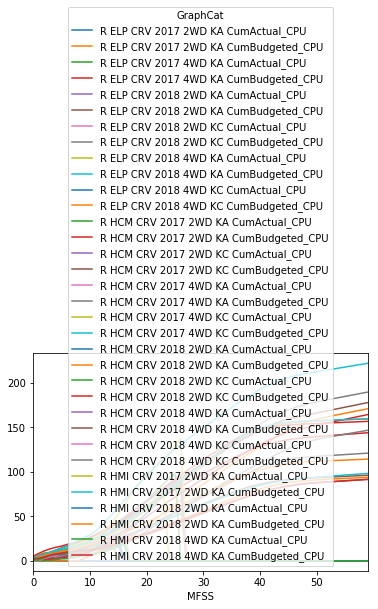

In [64]:
cpu_wide[:60].plot();

In [65]:
cpu_wide[:60].to_excel(r'D:\temp\chart_data_gc_level.xlsx')